In [22]:
import mujoco
from mujoco import minimize
import numpy as np
import mediapy as media
# from dm_control import mjcf
from pathlib import Path
import quaternion

## Setup
- models/lite6_viz.xml is an edited version of the lite6 model from mujoco_menagerie. Most crucially, a "target" body is added to visualise the target frame.
- In models/lite6_viz.xml, change the meshdir in line 2 to point to wherever mujoco_menagerie is cloned, to load the assets

In [260]:
# Load model XML

# robot_descriptions doesn't include ufactory lite 6, so we laod the XML from menagerie
# Also, there are a couple of edits needed to make to the deafult scene, so we make them in a file there
scene_path = "models/lite6_viz.xml"
model = mujoco.MjModel.from_xml_path(scene_path)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

""

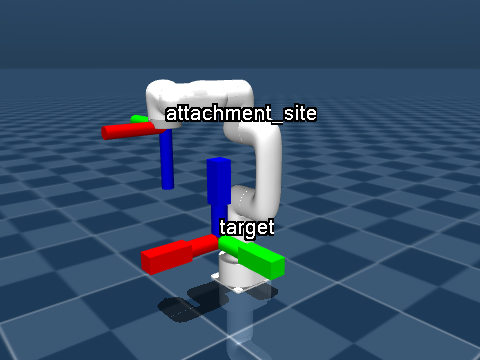

In [113]:
# Initial model visualisation and parameter setup
mujoco.mj_resetDataKeyframe(model, data, 0)
mujoco.mj_forward(model, data)

# Make a Renderer and a camera.
renderer = mujoco.Renderer(model, height=360, width=480)
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 1.2
camera.elevation = -15
camera.azimuth = -130
camera.lookat = (0, 0, 0.3)

# Visualize site frames and labels
voption = mujoco.MjvOption()
voption.frame = mujoco.mjtFrame.mjFRAME_SITE
voption.label = mujoco.mjtLabel.mjLABEL_SITE
renderer.update_scene(data, camera, scene_option=voption)
voption.label = mujoco.mjtLabel.mjLABEL_NONE

media.show_image(renderer.render())


In [263]:
# Joint ranges if you're interested
print(f"Joint ranges:\n{model.jnt_range}")
bounds = [model.jnt_range[:, 0], model.jnt_range[:, 1]]
x0 = model.key(0).qpos

Joint ranges:
[[-6.28319   6.28319 ]
 [-2.61799   2.61799 ]
 [-0.061087  5.23599 ]
 [-6.28319   6.28319 ]
 [-2.1642    2.1642  ]
 [-6.28319   6.28319 ]]


least_squares_solver docs:

```
Nonlinear Least Squares minimization with box bounds.

  Args:
    x0: Initial guess
    residual: Vectorized function returning the residual for 1 or more points.
    bounds: Optional pair of lower and upper bounds on the solution.
    jacobian: Optional function that returns Jacobian of the residual at a given
      point and residual. If not given, `residual` will be finite-differenced.
    norm: Norm object returning norm scalar or its projected gradient and
      Hessian. See Norm class for detailed documentation.
    eps: Perurbation used for automatic finite-differencing.
    mu_min: Minimum value of the regularizer.
    mu_max: Maximum value of the regularizer.
    mu_factor: Factor for increasing or decreasing the regularizer.
    tol: Termination tolerance on the step size.
    max_iter: Maximum number of iterations.
    verbose: Verbosity level.
    output: Optional file or StringIO to which to print messages.
    iter_callback: Optional iteration callback, takes trace argument.
    check_derivatives: Compare user-defined Jacobian and norm against fin-diff.
  ```

In [264]:
def ik(x, pos=None, quat=None, radius=0.04, reg=1e-3, reg_target=None, ref_frame='attachment_site'):
  """Residual for inverse kinematics.

  Args:
      x: numpy column vector of joint angles.
      pos: target position for the end effector.
      quat: target orientation for the end effector.
      radius: scaling of the 3D cross.

  Returns:
      The residual of the Inverse Kinematics task.
  """

  # Move the mocap body to the target
  id = model.body('target').mocapid
  data.mocap_pos[id] = model.body('target').pos if pos is None else pos
  data.mocap_quat[id] = model.body('target').quat if quat is None else quat

  res = []
  # For batched operation, each column can be a different x
  for i in range(x.shape[1]):
    # Forward kinematics for given state
    data.qpos = x[:, i]
    mujoco.mj_kinematics(model, data)

    # Position residual
    res_pos = data.site(ref_frame).xpos - data.site('target').xpos
    
    # Get the ref frame orientation (convert from rotation matrix to quaternion)
    ref_quat = np.empty(4)
    mujoco.mju_mat2Quat(ref_quat, data.site(ref_frame).xmat)

    # Target quat, exploit the fact that the site is aligned with the body.
    target_quat = data.body('target').xquat

    # Orientation residual: quaternion difference.
    res_quat = np.empty(3)
    mujoco.mju_subQuat(res_quat, target_quat, ref_quat)
    res_quat *= radius

    reg_target = reg_target if reg_target is not None else x0
    res_reg = reg * (x[:, i] - reg_target)
      
    res_i = np.hstack((res_pos, res_quat, res_reg))
    res.append(np.atleast_2d(res_i).T)
  
  return np.hstack(res)


In [265]:
def ik_jac(x, res, pos=None, quat=None, radius=0.04, reg=1e-3, ref_frame='attachment_site'):
  """Analytic Jacobian of inverse kinematics residual

  Args:
    x: joint angles.
    pos: target position for the end effector.
    quat: target orientation for the end effector.
    radius: scaling of the 3D cross.

  Returns:
    The Jacobian of the Inverse Kinematics task.
    (3 + 3 + nv)  * nv
  """
  mujoco.mj_kinematics(model, data)
  mujoco.mj_comPos(model, data) #calculate CoM position

  # Get end-effector site Jacobian.
  jac_pos = np.empty((3, model.nv))
  jac_quat = np.empty((3, model.nv))
  mujoco.mj_jacSite(model, data, jac_pos, jac_quat, data.site(ref_frame).id)

  # Get the ref frame orientation (convert from rotation matrix to quaternion)
  ref_quat = np.empty(4)
  mujoco.mju_mat2Quat(ref_quat, data.site(ref_frame).xmat)
  
  # Get Deffector, the 3x3 Jacobian for the orientation difference
  target_quat = data.body('target').xquat
  Deffector = np.empty((3, 3))
  mujoco.mjd_subQuat(target_quat, ref_quat, None, Deffector)

  # Rotate into target frame, multiply by subQuat Jacobian, scale by radius.
  target_mat = data.site('target').xmat.reshape(3, 3)
  mat =  Deffector.T @ target_mat.T
  jac_quat = radius * mat @ jac_quat

  # Regularization Jacobian
  jac_reg = reg * np.eye(model.nv)

  return np.vstack((jac_pos, jac_quat, jac_reg))

In [9]:
# Compare time to calculate analytical vs finite differenced methods
print('Finite-differenced Jacobian:')
x_fd, _ = minimize.least_squares(x0, ik, bounds, verbose=1)
print('Analytic Jacobian:')
x_analytic, _ = minimize.least_squares(x0, ik, bounds, jacobian=ik_jac,
                                       verbose=1, check_derivatives=True)

# Assert that we got a nearly identical solution
assert np.linalg.norm(x_fd - x_analytic) < 1e-5

Finite-differenced Jacobian:
Terminated after 13 iterations: norm(dx) < tol. y: 3.636e-05, Residual evals: 168
total time 15.7ms of which residual 80.7%
Analytic Jacobian:
User-provided Jacobian matches finite-differences.
Terminated after 13 iterations: norm(dx) < tol. y: 3.636e-05, Residual evals: 90, Jacobian evals: 14
total time 6.9ms of which residual 52.3% Jacobian 13.4%


""

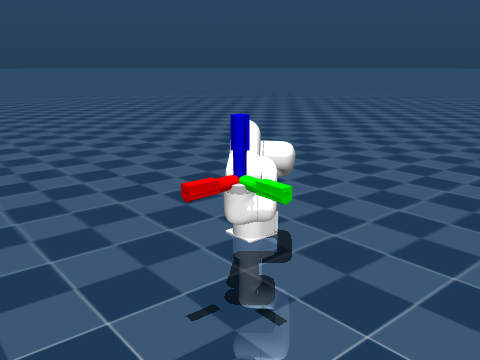

In [36]:
# Visualise the joint poses found by IK for the initial target pose
x, _ = minimize.least_squares(x0, ik, bounds, jacobian=ik_jac,
                              verbose=0)

# Update and visualize
data.qpos = x
mujoco.mj_kinematics(model, data)
mujoco.mj_camlight(model, data)
camera.distance = 1
camera.lookat = data.site('attachment_site').xpos
renderer.update_scene(data, camera, voption)
media.show_image(renderer.render())

In [153]:
# Functions for generating waypoints for test motions

def pose(time, speed=1):
  """
  Rotate around the origin, move up and down, rotate the end effector
  Args:
    time: time in seconds at which to calculate the pose
    speed: a factor by which to speed up the motion (or slow it down)
  """
  pos = (0.4 * np.sin(speed*time),
         0.4 * np.cos(speed*time),
         0.3 + 0.2 * np.sin(3 * speed*time))
  quat = np.array((1.0, np.sin(2 * speed * time), np.sin(speed*time), 0))
  quat /= np.linalg.norm(quat)
  return pos, quat

def pose_faceout(time, speed=1, init_quat=np.array((np.sqrt(2)/2, 0, np.sqrt(2)/2, 0))):
  """
  Rotate around the origin, move up and down, keep end effector facing outwards
  Args:
    time: time in seconds at which to calculate the pose
    speed: a factor by which to speed up the motion (or slow it down)
    init_quat: an initial rotation. The default gets z of the end effector facing outwards
  """

  pos = (0.4 * np.sin(speed*time),
         0.4 * np.cos(speed*time),
         0.35 + 0.1 * np.sin(3 * speed*time))
  # Angle around z axis
  theta = np.arctan2(pos[1], pos[0])
  # Convert to quaternion
  quat = np.array((np.cos(theta/2), 0, 0, np.sin(theta/2)))
  quat /= np.linalg.norm(quat)

  res_quat = np.zeros(4)
  mujoco.mju_mulQuat(res_quat, quat, init_quat)

  return pos, res_quat


In [267]:
# Render a video of the generated target path in mujoco

DURATION = 5          # seconds
FRAMERATE = 60        # Hz

# Reset the camera, make the arm point straight up.
camera.distance = 1.5
camera.elevation = -15
camera.azimuth = -130
camera.lookat = (0, 0, 0.3)
mujoco.mj_resetData(model, data)

frames = []
while data.time < DURATION:
  # Move the target
  pos, quat = pose_faceout(data.time)
  id = model.body('target').mocapid
  data.mocap_pos[id] = pos
  data.mocap_quat[id] = quat

  # mujoco.mj_camlight(model, data)
  mujoco.mj_step(model, data)
  mujoco.mj_kinematics(model, data)

  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data, camera, voption)
    frames.append(renderer.render())


media.show_video(frames)

In [268]:
# Now solve for the joint angles at each pose, move the arm, and visualise the solution

DURATION = 5          # seconds
frames = []
x = x0
mujoco.mj_resetData(model, data)
data.qpos = x0

while data.time < DURATION:
  # Move the target
  # pos, quat = pose(data.time, speed=1)
  pos, quat = pose_faceout(data.time, speed=1)

  x_prev = x.copy()

  # Define IK problem
  ik_target = lambda x: ik(x, pos=pos, quat=quat,
                           reg_target=x_prev, radius=0.5, reg=.1)
  jac_target = lambda x, r: ik_jac(x, r, pos=pos, quat=quat)

  x, _ = minimize.least_squares(x, ik_target, bounds,
                                jacobian=jac_target,
                                verbose=0)

  # mujoco.mj_camlight(model, data)
  mujoco.mj_step(model, data)
  mujoco.mj_kinematics(model, data)

  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data, camera, voption)
    frames.append(renderer.render())

media.show_video(frames, loop=False)

## Real life
Now let's try to make the real arm do this motion! We'll start with position control as we already have the poses.

XArm control modes: \
0: position control mode \
1: servo motion mode \
2: joint teaching mode \
3: cartesian teaching mode (invalid) \
4: joint velocity control mode \
5: cartesian velocity control mode \
6: joint online trajectory planning mode  \
7: cartesian online trajectory planning mode

In [170]:
from xarm.wrapper import XArmAPI
import time
import collections
ip = "192.168.1.185"

In [208]:
def quaternion_to_axis_angle(quat):
  """
  Converts a quaternion to axis-angle representation.

  Args:
    quat: A 4-element quaternion (w, x, y, z) or np.quaternion.

  Returns:
    A tuple containing the axis (a 3-element vector) and the angle (in radians).
  """

  # Extract the scalar and vector components of the quaternion
  if isinstance(quat, np.quaternion):
    w = quat.w
    x = quat.x
    y = quat.y
    z = quat.z
  else:
    w = quat[0]
    x = quat[1]
    y = quat[2]
    z = quat[3]

  # Calculate the angle
  angle = 2 * np.arccos(w)

  # Calculate the axis
  if angle == 0:
    axis = np.array([0, 0, 0])  # Zero vector if angle is zero
  else:
    axis = np.array([x, y, z]) * angle / np.linalg.norm(np.array([x, y, z]))

  return axis

In [287]:
def solve_ik(pos, quat, x0):
  """
  Solve for an end effector pose, return joint angles
  """
  if isinstance(quat, np.quaternion):
    quat = quaternion.as_float_array(quat)

  ik_target = lambda x: ik(x, pos=pos, quat=quat,
                          reg_target=x_prev, radius=0.05, reg=.1)
  # ik_target = lambda x: ik(x, pos=pos, quat=quat, radius=0.05, reg=.1)
  jac_target = lambda x, r: ik_jac(x, r, pos=pos, quat=quat)
  x, _ = minimize.least_squares(x0, ik_target, bounds,
                              jacobian=jac_target,
                              verbose=0)
  return x


def render_state(x, show=True):
  """
  Render arm position given joint angles, and optionally show
  """
  data.qpos = x

  mujoco.mj_kinematics(model, data)

  camera.lookat = data.site('attachment_site').xpos
  renderer.update_scene(data, camera, voption)
  pixels = renderer.render()
  if show:
    media.show_image(pixels)
  return pixels

def plot_pose(pos, quat, x0, show=True):
  """
  Solve for an end effector pose, render, and optionally show
  """
  x = solve_ik(pos, quat, x0)
  pixels = render_state(x, show=show)
  return x, pixels

def mujoco_to_xarm_pose(pos, quat):
  """
  Convert from position (in m) and quaternion to xarm axis-angle pose [x (mm), y (mm), z (mm), ax, ay, az]
  """
  pos_mm = np.array(pos)*1e3
  aang = quaternion_to_axis_angle(quat)
  return list(pos_mm) + list(aang)

def xarm_to_mujoco_pose(pos_aang):
  """
  Convert from xarm axis-angle pose [x (mm), y (mm), z (mm), ax, ay, az] to position (in m) and quaternion
  """
  angle = np.linalg.norm(pos_aang[3:])
  axis = pos_aang[3:]/angle

  quat = np.zeros(4)
  mujoco.mju_axisAngle2Quat(quat, axis, angle)

  pos = np.array(pos_aang)[:3]/1000.

  return pos, quat

# Check that the conversion functions are legit by converting back and forth
pos, quat = pose_faceout(0)
pose_xarm = mujoco_to_xarm_pose(pos, quat)
pos_recomp, quat_recomp = xarm_to_mujoco_pose(pose_xarm)
print(f"Orig: {pos}, {quat} should equal recomputed: {pos_recomp} {quat_recomp}")
print(f"Xarm axis angle: {pose_xarm}")

# ompare the np arrays
assert(np.allclose(pos, pos_recomp))
assert(np.allclose(quat, quat_recomp))
print("Success")

Orig: (0.0, 0.4, 0.35), [ 0.5 -0.5  0.5  0.5] should equal recomputed: [0.   0.4  0.35] [ 0.5 -0.5  0.5  0.5]
Xarm axis angle: [0.0, 400.0, 350.0, -1.209199576156145, 1.2091995761561454, 1.209199576156145]
Success


ROBOT_IP: 192.168.1.185, VERSION: v1.12.2, PROTOCOL: V1, DETAIL: 6,9,LI1006,DL1000,v1.12.2, TYPE1300: [0, 0]
change protocol identifier to 3


""

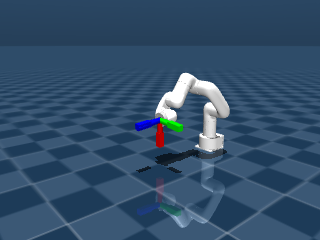

Current pos: [0.3975546  0.00140562 0.24339729], quat: [ 0.68224748 -0.0399232   0.72967812 -0.02267957]


""

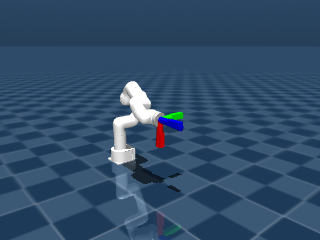

Init pos: (0.0, 0.4, 0.35), quat: [ 0.5 -0.5  0.5  0.5]


In [296]:
# Visualise current arm pose, and the new pose to get to
arm = XArmAPI(ip, is_radian=True)

x0 = model.key(0).qpos

# Apparently the reading is only valid if the code returned is 0
code, curr_xarm_aa_pose = arm.get_position_aa()
code2, state = arm.get_servo_angle()
if any((code, code2)):
  print(f"Invalid pos reading, codes: {(code, code2)}") 

curr_pos, curr_quat = xarm_to_mujoco_pose(curr_xarm_aa_pose)

# Visualise current pose in MuJoCo to compare to real life
# render_state(state) # can also be used to ensure consistency with frames of reference etc.
plot_pose(curr_pos, curr_quat, x0)
print(f"Current pos: {curr_pos}, quat: {curr_quat}")

# Visualise the pose we need to get to to start the motion
init_pos, init_quat = pose_faceout(0)
x = plot_pose(init_pos, init_quat, x0)
print(f"Init pos: {init_pos}, quat: {init_quat}")


Interpolation:
quaternion(0.682247476118977, -0.0399232022445659, 0.729678118179553, -0.0226795745500599)
quaternion(0.681581274831319, -0.0919677394467401, 0.725119639623625, 0.0345023032923095)
quaternion(0.676825841789546, -0.143460504740872, 0.716210715470998, 0.0914771802685708)
quaternion(0.668009707806513, -0.19409256086779, 0.703004795921795, 0.147903228507681)
quaternion(0.655185766376164, -0.243560134500182, 0.685581111535244, 0.203441912904968)
quaternion(0.638430956332422, -0.291566438768504, 0.664044197876062, 0.257760022205652)
quaternion(0.617845800245076, -0.337823453870773, 0.638523268340325, 0.310531668147281)
quaternion(0.593553801322097, -0.382053655083245, 0.609171438923593, 0.361440240666946)
quaternion(0.565700702436765, -0.423991677804562, 0.576164809582431, 0.410180307442793)
quaternion(0.534453611725143, -0.46338590964373, 0.539701407700778, 0.45645944637328)
quaternion(0.5, -0.5, 0.5, 0.5)


,,,,,,,,,,

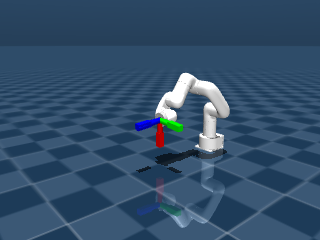
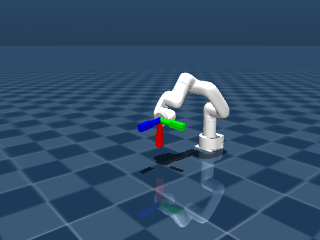
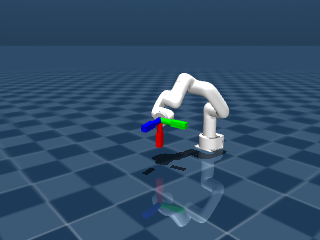
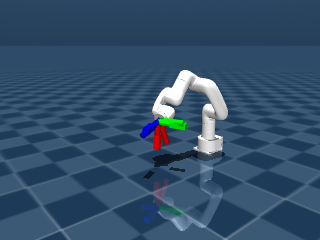
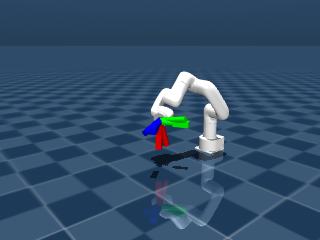
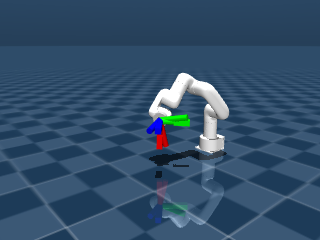
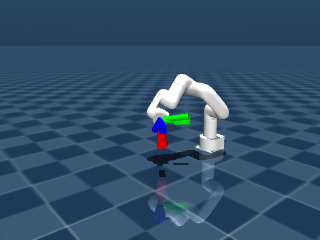
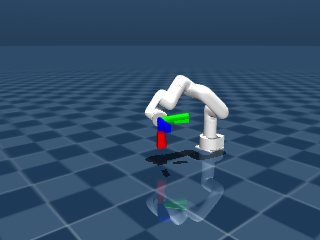
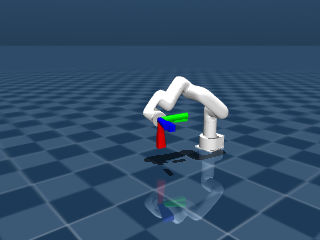
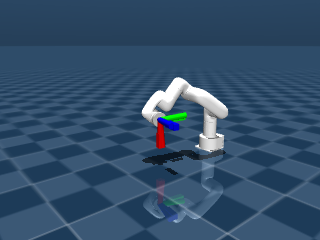
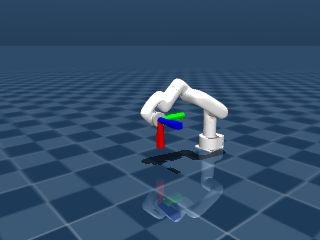

In [298]:
# Arm couldn't deal with end effector being flipped, so we interpolate from current to desired orientation
quat_waypoints = [np.slerp_vectorized(quaternion.as_quat_array(curr_quat), quaternion.as_quat_array(init_quat), x) for x in np.linspace(0, 1, 11)]

print("Interpolation:")
[print(quat) for quat in quat_waypoints]
frames = []
for quat in quat_waypoints:
  _, pixels = plot_pose(curr_pos, quat, x0, show=False)
  frames.append(pixels)

media.show_images(frames)

In [ ]:
# TODO: Twist interpolation


In [237]:
# Get the arm ready for motion
arm = XArmAPI(ip, is_radian=True)
arm.motion_enable(enable=True)
arm.set_mode(0)
arm.set_state(state=0)

init_xarm_aa_pose = mujoco_to_xarm_pose(init_pos, init_quat)

print(f"Curr pos: {curr_xarm_aa_pose}")
print(f"Goal pos: {init_xarm_aa_pose}")

ROBOT_IP: 192.168.1.185, VERSION: v1.12.2, PROTOCOL: V1, DETAIL: 6,9,LI1006,DL1000,v1.12.2, TYPE1300: [0, 0]
change protocol identifier to 3
[motion_enable], xArm is not ready to move
[set_state], xArm is ready to move
Curr pos: [-11.683849, 398.008301, 316.037201, -1.382581, 1.193216, 1.106478]
Goal pos: [0.0, 400.0, 350.0, -1.209199576156145, 1.2091995761561454, 1.209199576156145]


In [255]:
arm.set_state(state=0)
print("ready")

quat_waypoints = [np.slerp_vectorized(quaternion.as_quat_array(curr_quat), quaternion.as_quat_array(init_quat), x) for x in np.linspace(0, 1, 11)]
# arm.set_position_aa(mujoco_to_xarm_pose(curr_pos, curr_quat), speed=1, radius=None, wait=True)


for quat in quat_waypoints:
  # time.sleep(1)
  next_pose = mujoco_to_xarm_pose(curr_pos, quat)
  print(f"Move from {arm.get_position_aa()[1]} to {next_pose} ")
  arm.set_position_aa(next_pose, speed=100, radius=None, wait=True)



ready
Move from [-16.435173, 386.312927, 277.977112, -1.396388, 1.034322, 0.95484] to [-11.683849, 398.008301, 316.037201, -1.3825809999999998, 1.1932159999999996, 1.1064779999999999] 
Move from [-11.683849, 398.008301, 316.037201, -1.382581, 1.193216, 1.106478] to [-11.683849, 398.008301, 316.037201, -1.3654461434315517, 1.195124959828921, 1.117109915743029] 
Move from [-11.683849, 398.008301, 316.037201, -1.365446, 1.195125, 1.11711] to [-11.683849, 398.008301, 316.037201, -1.3482647535159245, 1.1969646133217304, 1.1276620940591213] 
Move from [-11.683849, 398.008301, 316.037201, -1.348265, 1.196965, 1.127662] to [-11.683849, 398.008301, 316.037201, -1.331037345224529, 1.1987350693294467, 1.1381344577772188] 
Move from [-11.683849, 398.008301, 316.037201, -1.331037, 1.198735, 1.138134] to [-11.683849, 398.008301, 316.037201, -1.3137644303428586, 1.2004364352795915, 1.148526929110037] 
Move from [-11.683849, 398.008301, 316.037201, -1.313764, 1.200436, 1.148527] to [-11.683849, 398.00

In [258]:
arm.set_state(state=0)

arm.set_position_aa(init_xarm_aa_pose, speed=50, radius=0, wait=True)

print("ready")

DURATION = 30
FRAMERATE = 10

t = 0
buff_len = int(FRAMERATE / 2)
tdiff = collections.deque(maxlen=buff_len)

start_time = time.time()

while time.time() < start_time + DURATION:
    loop_start = time.time()
    t = loop_start - start_time

    if (len(tdiff) > 0):
        tdiff.append(t - t_prev)
        # Print framerate every 0.5s
        if int(t*2) != int(t_prev*2):
          print(f"Rate: {1.0/np.array(tdiff).mean()}")

    pos, quat = pose_faceout(t, speed=0.2)
    
    arm.set_position_aa(mujoco_to_xarm_pose(pos, quat), speed=200, radius=None, wait=True)
    sleep_time = loop_start + 1.0/FRAMERATE - time.time()
    if sleep_time > 0:
      time.sleep(sleep_time)
    else:
      pass
    t_prev = t

# arm.motion_enable(enable=False)


ready
[SDK][ERROR][2024-06-13 12:02:41][base.py:380] - - wait_move, xarm is stop, state=4
[SDK][ERROR][2024-06-13 12:02:41][base.py:380] - - API -> set_position_aa -> code=1, pos=[394.28928637750386, -67.34952596654813, 262.60567777015996, 0.1328448339588961, 1.5667107800663511, -0.1328448339588961], velo=200.0, acc=2000
[SDK][ERROR][2024-06-13 12:02:41][base.py:380] - - API -> set_position_aa -> code=1, pos=[392.80278685240665, -75.5378755392472, 265.8075605961237, 0.14917379240622883, 1.5656436919986385, -0.14917379240622883], velo=200.0, acc=2000
[SDK][ERROR][2024-06-13 12:02:41][base.py:380] - - API -> set_position_aa -> code=1, pos=[391.1628739223121, -83.61582424898636, 269.30213602976227, 0.1653439667687022, 1.5644647303231902, -0.1653439667687022], velo=200.0, acc=2000
[SDK][ERROR][2024-06-13 12:02:41][base.py:380] - - API -> set_position_aa -> code=1, pos=[389.3201434919761, -91.81408318655237, 273.1818454886361, 0.18182490614330818, 1.5631377673928746, -0.18182490614330818], 

KeyboardInterrupt: 

In [227]:
# Use this to reset any errors
arm.reset()

[motion_enable], xArm is not ready to move
[set_state], xArm is ready to move
